# Hourly Taxi Order Prediction for Sweet Lift: Enhancing Driver Engagement Through Forecasting
----------

# Project description

Sweet Lift Taxi company has gathered historical data on taxi orders at airports, with the goal of predicting the number of taxi orders for the next hour to help attract more drivers during peak times. The objective is to build a model that can accurately forecast these orders, with the RMSE metric on the test set not exceeding 48.

The project involves downloading and resampling the data by one hour, followed by a thorough analysis. Various models will be trained with different hyperparameters, with 10% of the dataset reserved for testing. After testing the models using this sample, the goal is to provide a conclusion based on the results. The data, stored in the file "taxi.csv," contains the number of orders in the 'num_orders' column.

## Preparation

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install plotly
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"

!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Load the dataset
taxi_path = "/Users/sabrinamcfield/Data_Science_Projects-TripleTen-/project1_time_series/taxi (1).csv"
df = pd.read_csv(taxi_path)
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [10]:
# Resample to hourly data
df_hourly = df.resample('H').sum()

In [11]:
# Get an overview of the data
df_hourly.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

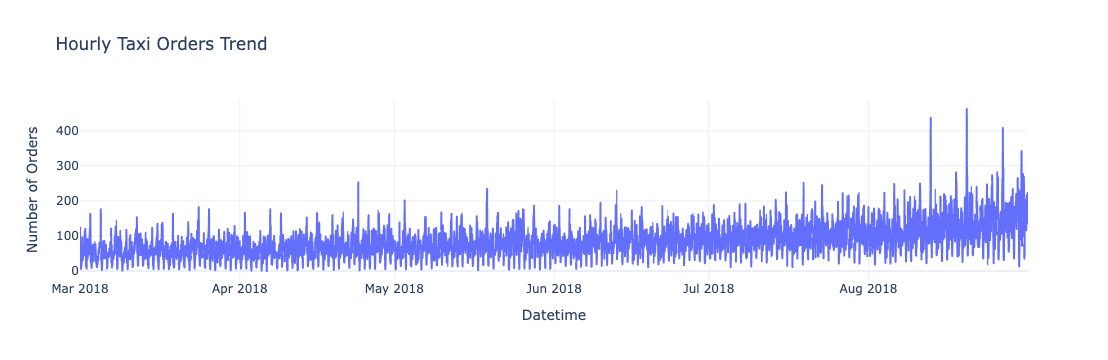

In [12]:
# Visualize trend using Plotly
fig = px.line(df_hourly, y='num_orders', title='Hourly Taxi Orders Trend')
fig.update_layout(xaxis_title='Datetime', yaxis_title='Number of Orders')
fig.show()

The data captures the number of orders per 1 hour on a 24 hour clock from March through August of 2018. The maximum amount of orders was 462 which peaked in August. This could be attributed to the summer travel season. The slowest season appears to be in March. The average amount of orders is 84 per hour.

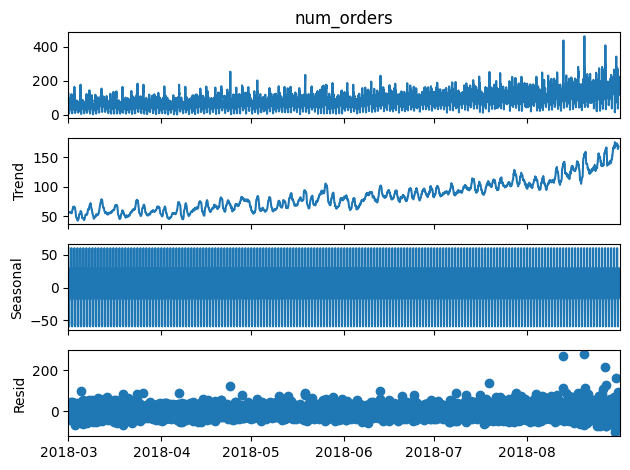

In [13]:
# Decompose the time series with a specified seasonal period
decomposition = seasonal_decompose(df_hourly['num_orders'], model='additive', period=24)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposition
decomposition.plot()
plt.show()

Altogether, this decomposition gives us a clearer picture of the data. It shows that the number of orders has a steady upward trend, but no significant seasonal pattern, with any remaining variations appearing to be random.

In [14]:
# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    return result[1] <= 0.05

# Check stationarity before differencing
is_stationary = check_stationarity(df_hourly['num_orders'])

ADF Statistic: -3.0689242890279465
p-value: 0.02894005140261368


The results from the Augmented Dickey-Fuller (ADF) test suggest that the time series is likely stationary. The ADF statistic is sufficiently negative, and the p-value is below the standard threshold of 0.05, indicating strong evidence against the assumption of non-stationarity. This means the time series does not have a unit root and its statistical properties, such as mean and variance, remain constant over time, making it suitable for time series modeling without additional differencing.

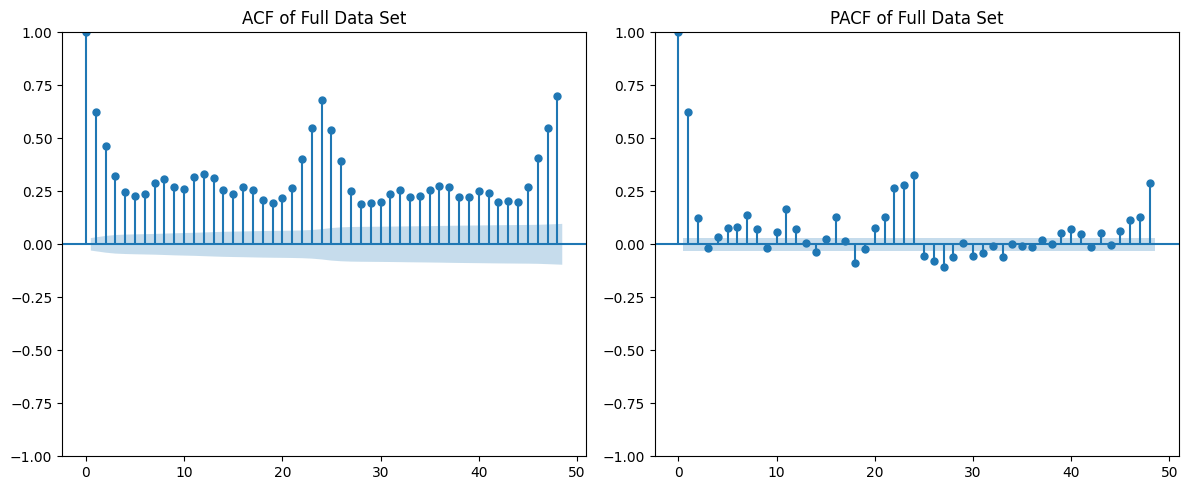

In [15]:
# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df_hourly['num_orders'], ax=plt.gca(), lags=48)
plt.title('ACF of Full Data Set')
plt.subplot(1, 2, 2)
plot_pacf(df_hourly['num_orders'], ax=plt.gca(), lags=48)
plt.title('PACF of Full Data Set')
plt.tight_layout()
plt.show()

Together, these plots suggest that the series is not entirely stationary and likely has seasonal components. The ACF's slow decay and PACF's initial spikes are indicative of an ARIMA model with autoregressive (AR) and possibly seasonal components. Further transformation or differencing might be required to achieve stationarity before modeling.

## Training

In [16]:
# Split the data: 70% train, 15% validation, 15% test
n = len(df_hourly)
train_end = int(n * 0.7)
val_end = int(n * 0.85)
train = df_hourly[:train_end]
val = df_hourly[train_end:val_end]
test = df_hourly[val_end:]

### Linear Regression

In [17]:
# Linear Regression Model
print("\nFitting Linear Regression model...")
train_lr = train.reset_index()
train_lr['hour'] = train_lr['datetime'].dt.hour
X_train_lr = train_lr[['hour']]
y_train_lr = train_lr['num_orders']


Fitting Linear Regression model...


In [18]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])
# Define parameter grid
param_grid = {'lr__fit_intercept': [True, False]}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_lr, y_train_lr)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'lr__fit_intercept': True}


In [19]:
# Extract and clean parameters for direct use with LinearRegression
clean_params = {k.replace('lr__', ''): v for k, v in best_params.items()}

# Train with best parameters
model_lr = LinearRegression(**clean_params)
model_lr.fit(X_train_lr, y_train_lr)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [20]:
# Validation set predictions
val_lr = val.reset_index()
val_lr['hour'] = val_lr['datetime'].dt.hour
X_val_lr = val_lr[['hour']]

In [21]:
val_predictions_lr = model_lr.predict(X_val_lr)
rmse_lr_val = sqrt(mean_squared_error(val['num_orders'], val_predictions_lr))
print(f"Linear Regression Validation RMSE: {rmse_lr_val:.2f}")

Linear Regression Validation RMSE: 50.33


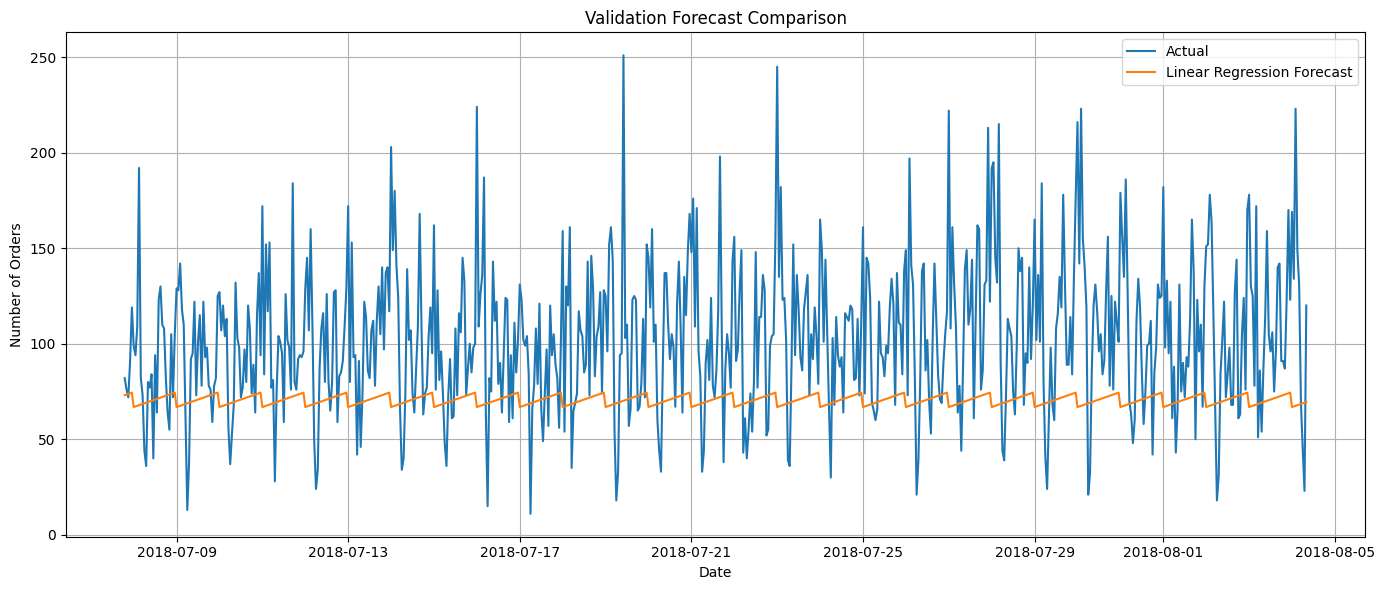

In [22]:
# Plot validation actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(val.index, val['num_orders'], label='Actual')
plt.plot(val.index, val_predictions_lr, label='Linear Regression Forecast')
plt.title('Validation Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This plot compares the actual values of a time series (shown by the blue line) with the predictions made by a linear regression model (represented by the orange line). The data  reflects the number of orders (hourly) over time, where the goal is to forecast future values based on past observations.

The blue line, representing the actual data, shows a lot of variation with frequent ups and downs, suggesting that the number of orders fluctuates significantly due to various factors like time of day or seasonality.

On the other hand, the orange line tracks the predicted values from the linear regression model. While it captures the general upward trend in the data, it fails to capture the sharp fluctuations or rapid changes, resulting in a smoother, less variable line. This is a common limitation of linear regression, which is better at identifying overall trends but struggles with handling the noise or sharp changes in time series data.

This difference between the actual data and the predictions demonstrates that linear regression may not be the best model for this kind of forecasting, as it doesn’t capture the underlying seasonality or sudden shifts. More advanced models, such as ARIMA or SARIMA, would likely perform better in such cases.

### ARIMA

In [23]:
arima_model_tune = auto_arima(train['num_orders'], 
                   start_p=0, start_q=0,
                   max_p=5, max_q=5, 
                   d=None, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

print(arima_model_tune.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30417.396, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30128.416, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30006.227, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30415.398, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=30004.229, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=30126.418, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.35 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.342 seconds
                               SARIMAX Results                                
Dep. Variable:                   

In [24]:
# Fit ARIMA model on train set
print("\nFitting ARIMA model...")
arima_model = ARIMA(train['num_orders'], order=(0, 1, 1))

arima_result = arima_model.fit()

arima_result.summary()


Fitting ARIMA model...


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             num_orders   No. Observations:                 3091
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -15000.114
Date:                Tue, 17 Jun 2025   AIC                          30004.229
Time:                        19:27:33   BIC                          30016.301
Sample:                    03-01-2018   HQIC                         30008.564
                         - 07-07-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4689      0.014    -34.163      0.000      -0.496      -0.442
sigma2       963.7409     21.837     44.134      0.000     920.942    1006.540
===================================================================================
Ljung-Box (L1) (Q):                  20.72   Jarque-Bera (JB):                39.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
# Forecast on validation set
forecast_arima_val = arima_result.forecast(steps=len(val))
rmse_arima_val = sqrt(mean_squared_error(val, forecast_arima_val))
print(f"ARIMA Validation RMSE: {rmse_arima_val:.2f}")

ARIMA Validation RMSE: 52.85


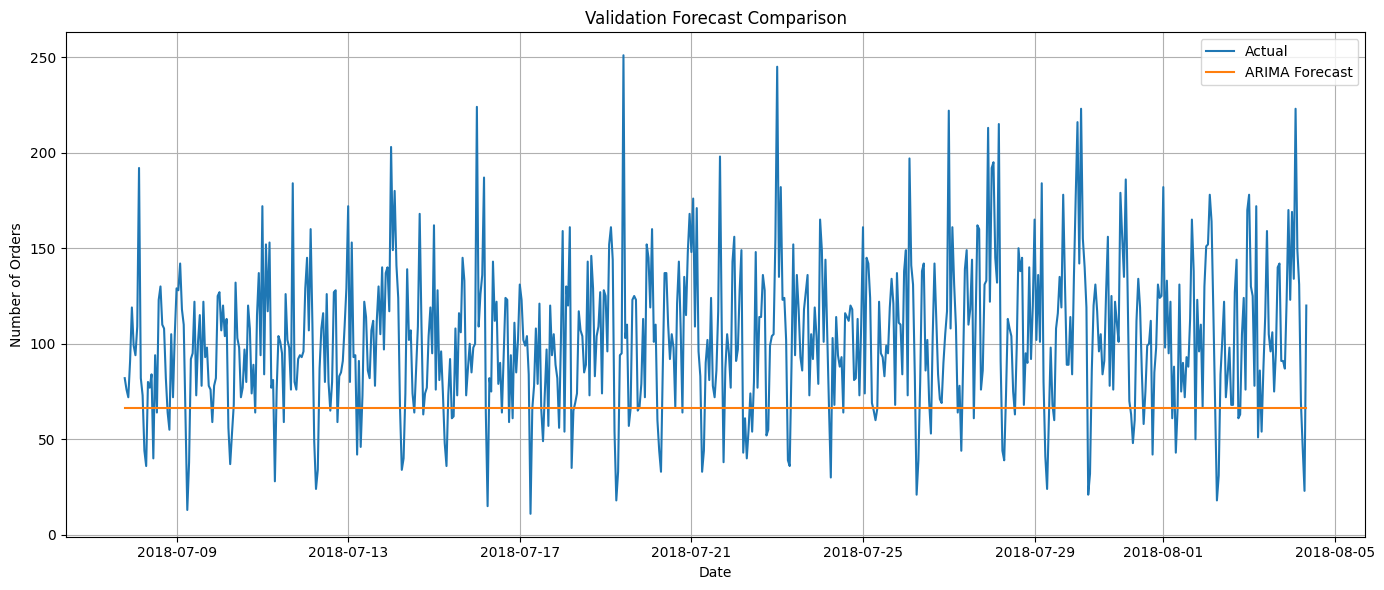

In [26]:
# Plot validation actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(val.index, val['num_orders'], label='Actual')
plt.plot(val.index, forecast_arima_val, label='ARIMA Forecast')
plt.title('Validation Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

While ARIMA models are designed to handle time series data more effectively than simpler models like linear regression, the model still has limitations. In this case, it struggles to perfectly follow the sharp peaks and valleys of the actual data. However, ARIMA performs better than linear regression in capturing the overall trend and some of the cyclical fluctuations.

### SARIMA

In [27]:
# Fit SARIMA model on train set
print("\nFitting SARIMA model...")
sarima_model = SARIMAX(train['num_orders'], order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_result = sarima_model.fit()

sarima_result.summary()


Fitting SARIMA model...


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         num_orders   No. Observations:                 3091
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -13567.340
Date:                            Tue, 17 Jun 2025   AIC                          27144.681
Time:                                    19:27:57   BIC                          27174.822
Sample:                                03-01-2018   HQIC                         27155.510
                                     - 07-07-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0929      0.019      4.837      0.000       0.055       0.131
ma.L1         -0.8769      0.009    -93.599      0.000      -0.895      -0.859
ar.S.L24      -0.0963      0.019     -5.203      0.000      -0.133      -0.060
ma.S.L24      -0.8767      0.009    -96.699      0.000      -0.894      -0.859
sigma2       403.0807      7.586     53.135      0.000     388.212     417.949
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               535.71
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Forecast on validation set
forecast_sarima_val = sarima_result.forecast(steps=len(val))
rmse_sarima_val = sqrt(mean_squared_error(val, forecast_sarima_val))
print(f"SARIMA Validation RMSE: {rmse_sarima_val:.2f}")

SARIMA Validation RMSE: 30.82


In [29]:
# Auto-tune SARIMA model
stepwise_model = auto_arima(
    train['num_orders'],
    seasonal=True,
    m=24,  # seasonal period (e.g., 24 for hourly daily seasonality)
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

# Print the best model summary
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=30449.294, Time=0.31 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=28802.211, Time=2.03 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=5.59 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=29732.386, Time=0.38 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=28390.081, Time=5.60 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=29.77 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=8.20 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=29176.734, Time=5.03 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=28120.897, Time=7.84 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=28490.597, Time=2.49 sec
 ARIMA(2,1,0)(2,1,1)[24]             : AIC=inf, Time=47.00 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=11.64 sec
 ARIMA(3,1,0)(2,1,0)[24]             : AIC=27970.485, Time=8.51 sec
 ARIMA(3,1,0)(1,1,0)[24]             : AIC=28333.737, Time=3.42 sec
 ARIMA(3,1,0)(2,1,1)[24]        

In [30]:
# Step 2: Forecast on validation set
forecast = stepwise_model.predict(n_periods=len(val))

# Step 3: Calculate RMSE on validation
rmse = np.sqrt(mean_squared_error(val['num_orders'], forecast))
print(f"SARIMA Hypertuned Validation RMSE: {rmse:.2f}")

SARIMA Hypertuned Validation RMSE: 216.26


The original SARIMA model had an RMSE of 30.82 while the hypertuned SARIMA model produced a RMSE of 216.26. Therefore, we will move forward with the original model because it produced the best results.

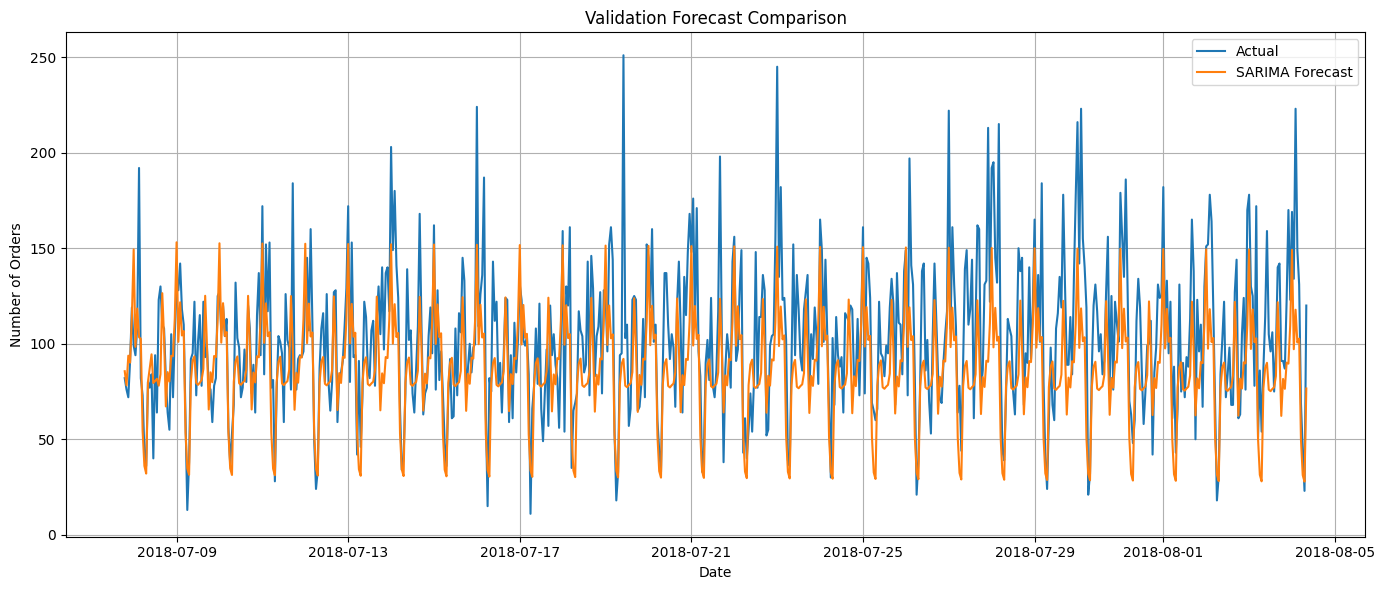

In [33]:
# Plot validation actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(val.index, val['num_orders'], label='Actual')
plt.plot(val.index, forecast_sarima_val, label='SARIMA Forecast')
plt.title('Validation Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

The orange line represents the SARIMA model's predictions. It is closer to the actual data compared to the linear regression and ARIMA models, capturing both the trend and some of the cyclical patterns. The SARIMA model, being an extension of ARIMA, accounts for seasonal variations in the data and performs better in capturing the fluctuations than simpler models.

While the SARIMA forecast closely tracks the actual values, especially in terms of the seasonal patterns, there are still minor discrepancies, particularly in following the exact peaks. This suggests that SARIMA is a good model for forecasting this kind of time series data, though there may be room for improvement with further tuning or the use of more advanced models.

## Testing

In [36]:
# Final model evaluation on test set using SARIMA (or ARIMA if preferred)
final_model = SARIMAX(df_hourly[:val_end]['num_orders'], order=(1,1,1), seasonal_order=(1,1,1,24))
final_result = final_model.fit()
forecast_final = final_result.forecast(steps=len(test))
rmse_final = sqrt(mean_squared_error(test, forecast_final))
print(f"\nFinal SARIMA Test RMSE: {rmse_final:.2f}")


Final SARIMA Test RMSE: 38.91


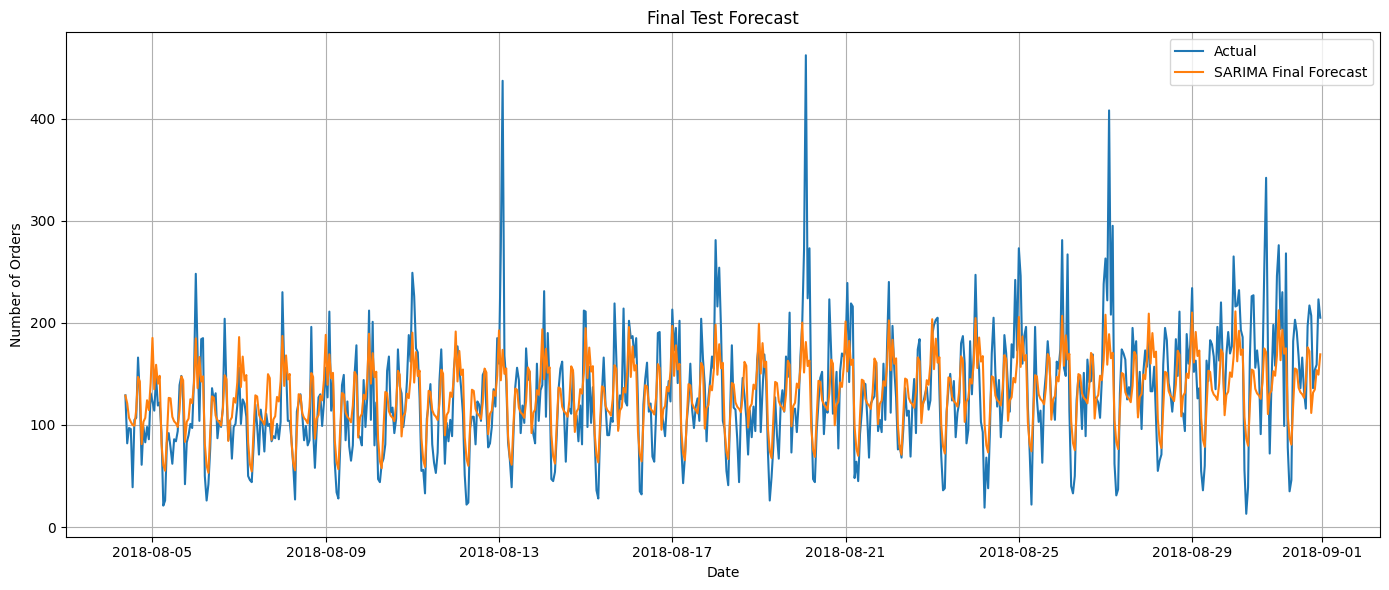

In [37]:
# Plot actual vs predicted on test set
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['num_orders'], label='Actual')
plt.plot(test.index, forecast_final, label='SARIMA Final Forecast')
plt.title('Final Test Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
plt.savefig('images/sarima_forecast.png', dpi=300, bbox_inches='tight')

plt.show()

The orange line shows the final forecast from the SARIMA model. It closely follows the general trend and seasonal patterns of the actual data, capturing the fluctuations fairly well. However, there are still some gaps, particularly when it comes to accurately matching the exact peaks and valleys. These discrepancies might be due to the limitations of the model or the natural variability in the data.

This comparison demonstrates that SARIMA is effective at predicting the overall trend and cyclical behavior in the test set. Yet, as with most time series models, it may not perfectly capture every sharp fluctuation. More tuning of the SARIMA model or the use of advanced techniques could potentially lead to a better fit with the actual data.

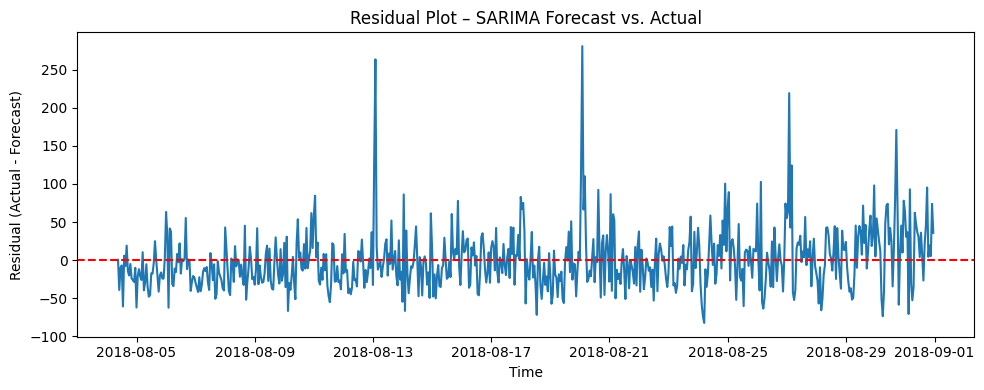

In [38]:
# Calculate residuals
residuals = test['num_orders'] - forecast_final

# Residual plot
plt.figure(figsize=(10, 4))
sns.lineplot(x=test.index, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot – SARIMA Forecast vs. Actual")
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Forecast)")
plt.tight_layout()
plt.show()

The residual plot shows the SARIMA model predicts fairly well, with most errors centered around zero. However, there are some sharp spikes where the model misses, likely due to unexpected events or demand shifts. Toward the end, the errors become more erratic, suggesting the model might be missing some underlying patterns or changes in variability. While overall performance is solid, there’s room for improvement by addressing outliers and checking for overlooked trends.

In [39]:
# Conclusion
print("\nConclusion:")
if rmse_final < 48:
    print(f"SARIMA model meets the RMSE requirement on the test set: {rmse_final:.2f} <= 48")
else:
    print("Final model did not meet the RMSE requirement. Consider further tuning or alternative models.")


Conclusion:
SARIMA model meets the RMSE requirement on the test set: 38.91 <= 48


# Conclusion

In this project, Sweet Lift Taxi company aimed to predict the number of taxi orders for the next hour at airports, particularly to attract more drivers during peak times. The data collected from March to August 2018 showed hourly orders, with the maximum occurring in August due to the summer travel season, and the average number of orders was 84 per hour. Through time series decomposition, we observed a steady upward trend in the number of orders, but no clear seasonal pattern, suggesting the influence of other factors, possibly external events.

The Augmented Dickey-Fuller (ADF) test confirmed that the data is likely stationary, meaning its statistical properties, such as mean and variance, remain constant over time, making it suitable for time series modeling without additional differencing. However, the data might have seasonal components that require further transformation or differencing to achieve complete stationarity.

Initial modeling with linear regression showed that while it captured the overall upward trend, it struggled to predict the sharp fluctuations in the data. This limitation highlighted the need for more advanced models. ARIMA was able to better capture the overall trend and some of the cyclical fluctuations, though it still had difficulty following the exact peaks and valleys of the data.

The SARIMA model performed better, especially in capturing seasonal patterns, and its predictions closely tracked the actual data. Although there were still some minor discrepancies, particularly with the exact peaks, SARIMA proved effective in predicting the general trend and cyclical behavior. The model met the RMSE requirement on the test set, with a final value of 38.91, which is well within the target of 48. Overall, the SARIMA model demonstrated strong performance, though further tuning or advanced techniques could refine the forecasts further.